<a href="https://colab.research.google.com/github/ee-689-boun/tsdl/blob/main/ar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall statsmodels -y
!pip install statsmodels pmdarima yfinance

Uninstalling statsmodels-0.10.2:
  Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 9.5MB 9.0MB/s 
     |████████████████████████████████| 1.5MB 57.0MB/s 
     |████████████████████████████████| 2.1MB 45.9MB/s 
     |████████████████████████████████| 5.5MB 49.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=de0eae1c15ad5c91817f988860a724239ab07e373b2a3235f69d37c8aa532465
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import random
import pmdarima as pm

In [ ]:
neuralprophetpath = "/content/drive/MyDrive/tsdl/Package/neural_prophet-master"

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git

# Data Prep

## Yahoo Data

In [ ]:
yahoo_data = yf.download("EURUSD=X", start="2017-01-01", end="2020-03-01")
yahoo_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,1.053075,1.054074,1.046572,1.052698,1.052698,0
2017-01-03,1.045916,1.049208,1.034768,1.046003,1.046003,0
2017-01-04,1.041840,1.047889,1.039134,1.041992,1.041992,0
2017-01-05,1.049869,1.060895,1.048658,1.050089,1.050089,0
2017-01-06,1.060558,1.060895,1.053963,1.060592,1.060592,0


In [ ]:
yahoo_data.shape

(802, 6)

In [ ]:
yahoo_data.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-17,1.084058,1.085400,1.083025,1.084175,1.084175,0
2020-02-18,1.083705,1.083900,1.078691,1.084011,1.084011,0
2020-02-19,1.079471,1.080847,1.078360,1.079540,1.079540,0
2020-02-20,1.080964,1.082100,1.077958,1.081010,1.081010,0
2020-02-21,1.078772,1.086366,1.078772,1.078800,1.078800,0
2020-02-24,1.083858,1.086366,1.080847,1.083905,1.083905,0
2020-02-25,1.084905,1.088175,1.083177,1.084920,1.084920,0
2020-02-26,1.088100,1.090358,1.085564,1.088200,1.088200,0
2020-02-27,1.088566,1.100570,1.088566,1.088589,1.088589,0


In [ ]:
yahoo_data = yahoo_data.rename(columns={"Adj Close": "EURUSD"})
yahoo_data = yahoo_data[["EURUSD"]]
yahoo_data.head()

,EURUSD
Date,
2017-01-02,1.052698
2017-01-03,1.046003
2017-01-04,1.041992
2017-01-05,1.050089
2017-01-06,1.060592


In [ ]:
def find_missing_dates(df):
  all_dates = pd.date_range(start=df.index.min(), 
                            end=df.index.max())
  return [date for date in all_dates.difference(df.index) 
          if not date.dayofweek in [5, 6]]

In [ ]:
find_missing_dates(yahoo_data)

[Timestamp('2017-07-11 00:00:00'),
 Timestamp('2017-11-16 00:00:00'),
 Timestamp('2019-05-22 00:00:00'),
 Timestamp('2019-09-11 00:00:00'),
 Timestamp('2019-09-12 00:00:00'),
 Timestamp('2019-09-13 00:00:00'),
 Timestamp('2019-09-16 00:00:00'),
 Timestamp('2019-09-17 00:00:00'),
 Timestamp('2019-09-18 00:00:00'),
 Timestamp('2019-09-19 00:00:00'),
 Timestamp('2019-09-20 00:00:00'),
 Timestamp('2019-09-23 00:00:00'),
 Timestamp('2019-09-24 00:00:00'),
 Timestamp('2019-09-25 00:00:00'),
 Timestamp('2019-09-26 00:00:00'),
 Timestamp('2019-09-27 00:00:00'),
 Timestamp('2019-09-30 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-10-02 00:00:00'),
 Timestamp('2019-10-03 00:00:00'),
 Timestamp('2019-10-04 00:00:00'),
 Timestamp('2019-10-07 00:00:00'),
 Timestamp('2019-10-09 00:00:00')]

In [ ]:
ts = yahoo_data.resample("1D").interpolate(method='time')

In [ ]:
train = ts[ts.index < "2020-01-01"]
test = ts[(ts.index >= "2020-01-01") & (ts.index <= "2020-02-01")]

## Investing Data

### Data Load

In [4]:
PATH = "/content/drive/MyDrive/tsdl/Data/"

In [5]:
FNAME = "EUR_USD_Data.csv"

In [6]:
inv_data_raw = pd.read_csv(f'{PATH}{FNAME}', low_memory=False, parse_dates=["Date"])

In [7]:
inv_data_raw.head()

,Date,Price,Open,High,Low,Change %
0,2021-01-29,1.2136,1.2121,1.2156,1.2093,0.12%
1,2021-01-28,1.2121,1.2109,1.2142,1.2079,0.11%
2,2021-01-27,1.2108,1.2160,1.2170,1.2057,-0.43%
3,2021-01-26,1.2160,1.2138,1.2177,1.2107,0.19%
4,2021-01-25,1.2137,1.2168,1.2184,1.2115,-0.25%


### Check Missing Dates

In [8]:
def find_missing_dates(df):
  all_dates = pd.date_range(start=df.index.min(), 
                            end=df.index.max())
  return [date for date in all_dates.difference(df.index) 
          if not date.dayofweek in [5, 6]]

In [9]:
len(find_missing_dates(inv_data_raw))

1

### Datatype Conversion

In [10]:
inv_data =  inv_data_raw.copy()

In [11]:
inv_data.dtypes

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Change %            object
dtype: object

In [12]:
inv_data = inv_data[["Date", "Price", "Change %"] ]

In [13]:
inv_data.head()

,Date,Price,Change %
0,2021-01-29,1.2136,0.12%
1,2021-01-28,1.2121,0.11%
2,2021-01-27,1.2108,-0.43%
3,2021-01-26,1.2160,0.19%
4,2021-01-25,1.2137,-0.25%


In [14]:
inv_data.loc[:,"Change %"] = inv_data["Change %"].apply(lambda x:  x[:-1] ).astype(np.float32)
inv_data = inv_data.reindex(range(len(inv_data)-1,-1,-1))
inv_data.reset_index(drop=True, inplace=True)
inv_data.index = inv_data.Date
inv_data.drop("Date",1, inplace=True)
inv_data.rename(columns={"Price": "EURUSD"},inplace=True)
invts = inv_data.resample("1D").interpolate(method='time'); invts.head()

,EURUSD,Change %
Date,,
2017-01-02,1.0459,-0.54
2017-01-03,1.0406,-0.51
2017-01-04,1.0488,0.79
2017-01-05,1.0607,1.13
2017-01-06,1.0533,-0.70


### Train-Valid-Test Split

In [15]:
trainidx = range(0,len(invts) -14)
valididx = range(len(invts) - 14, len(invts) - 7 )
testidx = range(len(invts) -7 , len(invts) )

train = invts.iloc[trainidx]
valid = invts.iloc[valididx]
test = invts.iloc[testidx]

# ACF - PACF

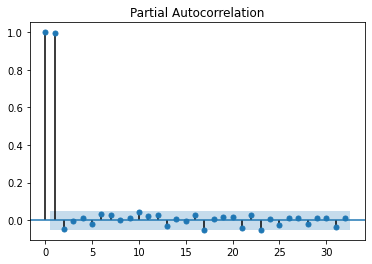

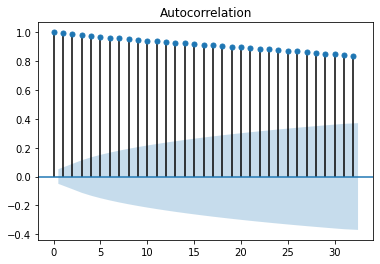

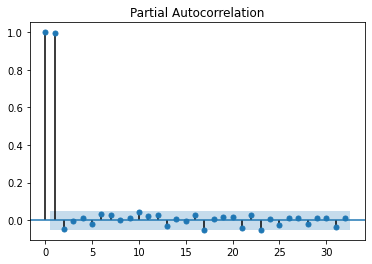

In [ ]:
plot_acf(invts.iloc[:,0]);
plot_pacf(invts.iloc[:,0])

# AR Model

In [ ]:
modelAR = AutoReg(train, lags=14)
modelAR_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Coefficients: intercept     0.005217
EURUSD.L1     1.013952
EURUSD.L2     0.006860
EURUSD.L3    -0.027439
EURUSD.L4    -0.036004
EURUSD.L5     0.046911
EURUSD.L6    -0.050076
EURUSD.L7     0.027207
EURUSD.L8     0.004948
EURUSD.L9     0.003125
EURUSD.L10   -0.034624
EURUSD.L11    0.046182
EURUSD.L12    0.038210
EURUSD.L13   -0.081066
EURUSD.L14    0.037307
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [ ]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
mape = abs(predictions/test["EURUSD"] - 1).mean()
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 0.013
Test MAPE: 0.010


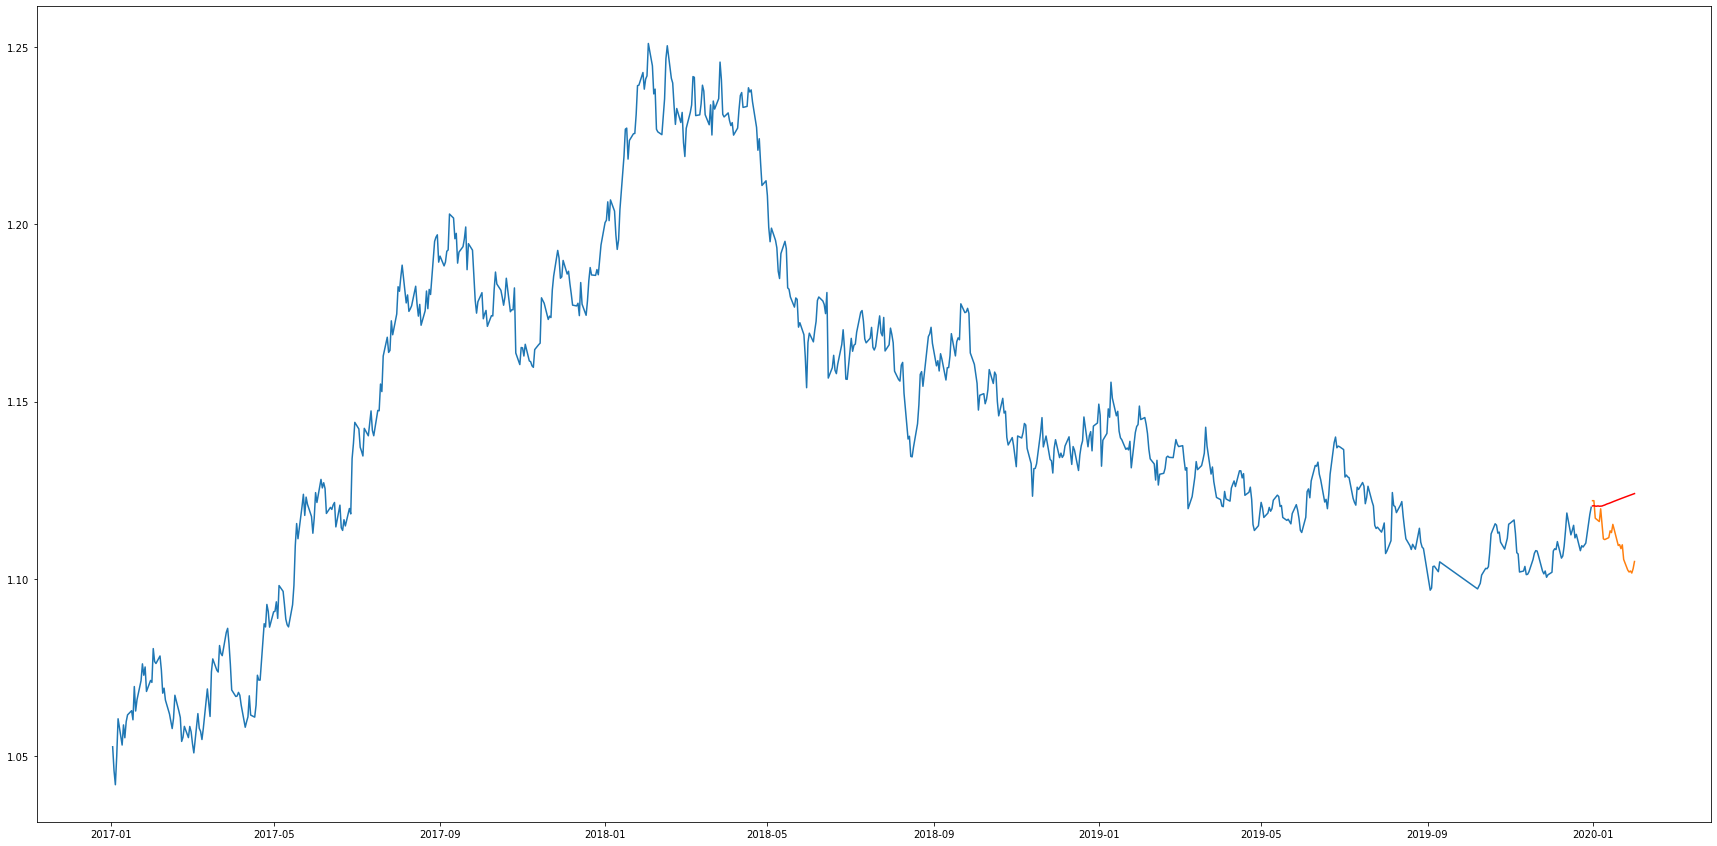

In [ ]:
plt.figure(figsize=(30, 15))
# plt.plot(train.iloc[-75:])
plt.plot(train)
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# AutoARIMA

In [ ]:
model = pm.auto_arima(train)

In [ ]:
forecasts = model.predict(test.shape[0])  # predict N steps into the future
predictions = pd.Series(forecasts, index=test.index)

In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
mape = abs(predictions/test["EURUSD"] - 1).mean()
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 0.011
Test MAPE: 0.009


In [ ]:
model

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

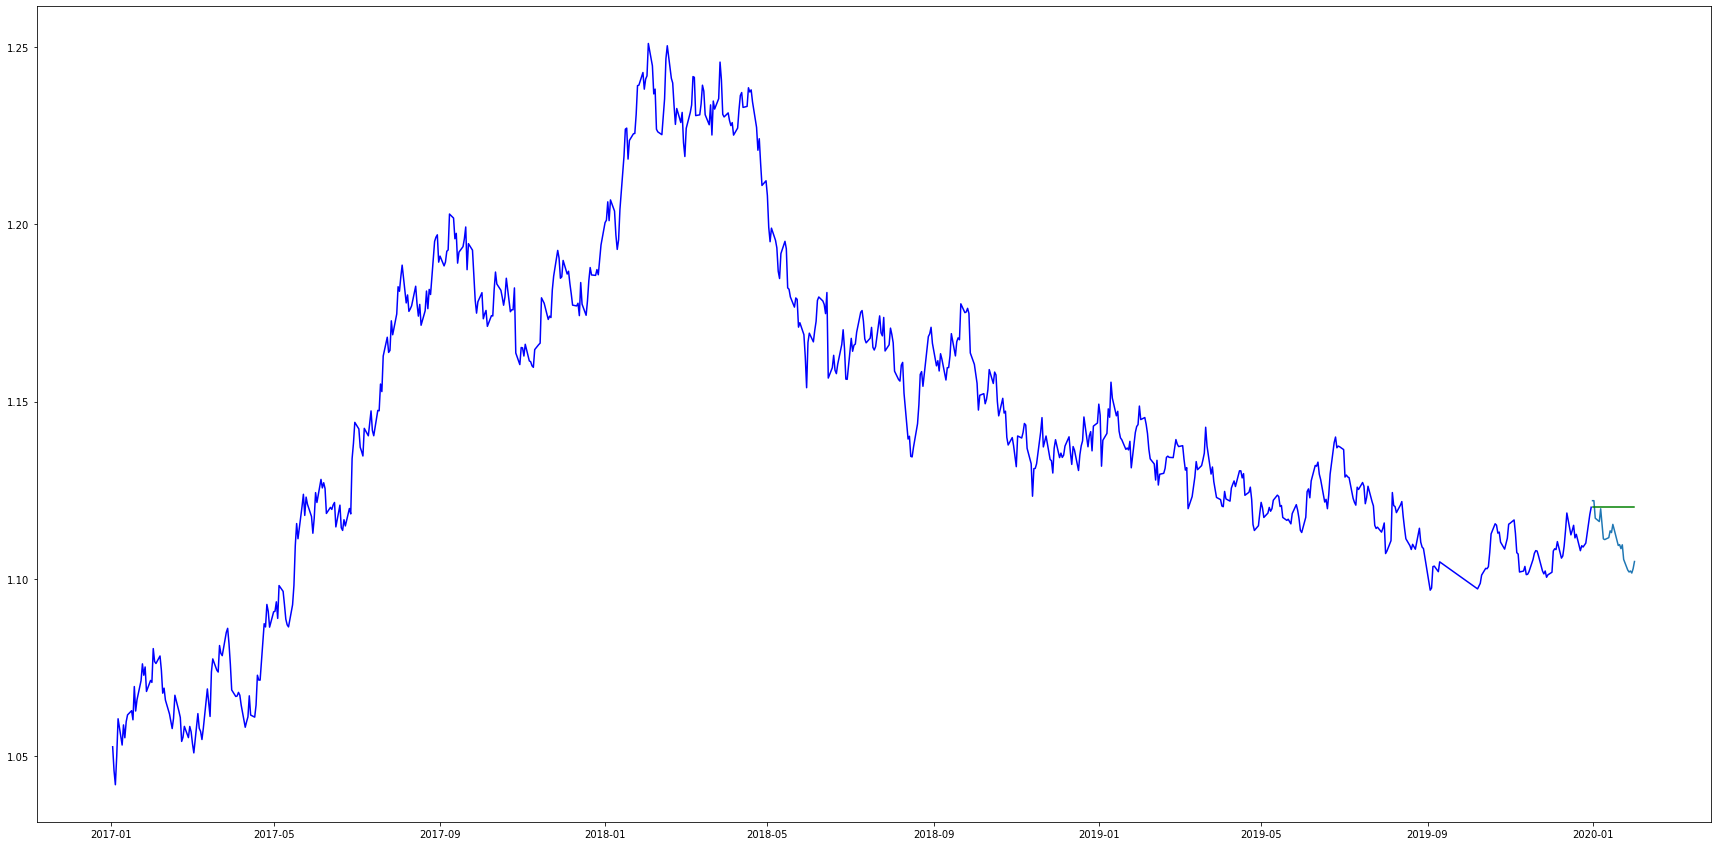

In [ ]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(train.shape[0] + test.shape[0])
plt.figure(figsize=(30, 15))
plt.plot(train, c='blue')
plt.plot(test)
plt.plot(predictions, c='green')
plt.show()

# AR-Net

In [16]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras import initializers
from keras import activations

## Hyperparameters

In [204]:
lr = 0.01
batch_size = 256
epochs = 100
lag = 7
step = 0

## Preparing AR-Net Data

In [205]:
from sklearn.preprocessing import MinMaxScaler

In [206]:
# scaler = MinMaxScaler()
# invts["normEURUSD"] = scaler.fit_transform(invts["EURUSD"][:,None])
# inverse = scaler.inverse_transform(invts)

In [207]:
invts.head()

,EURUSD,Change %
Date,,
2017-01-02,1.0459,-0.54
2017-01-03,1.0406,-0.51
2017-01-04,1.0488,0.79
2017-01-05,1.0607,1.13
2017-01-06,1.0533,-0.70


In [208]:
def CreateKLagDF(df, colname, lag = 3, step = 0):
  resdf = df.copy()
  for i in range(1,lag+1):
    label = "lag" + str(i)
    a = np.array(i*[None])
    b = np.array(resdf[colname][:-i])
    
    newcol = np.concatenate([a, b], axis= 0)
    resdf[label] = newcol.astype(np.float64)

  for i in range(1,step+1):
    label = "step" + str(i)
    a = np.array(resdf[colname][i:])
    b = np.array(i*[None])

    newcol = np.concatenate([a, b], axis= 0)
    resdf[label] = newcol.astype(np.float64)
    
  return resdf


In [209]:
arnetinv = CreateKLagDF(invts,"EURUSD", lag = lag, step = step);arnetinv.dtypes

EURUSD      float64
Change %    float32
lag1        float64
lag2        float64
lag3        float64
lag4        float64
lag5        float64
lag6        float64
lag7        float64
dtype: object

In [210]:
arnetinv = arnetinv.iloc[lag:,:] ; arnetinv.head()

,EURUSD,Change %,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Date,,,,,,,,,
2017-01-09,1.0574,0.39,1.056033,1.054667,1.053300,1.060700,1.048800,1.040600,1.0459
2017-01-10,1.0554,-0.19,1.057400,1.056033,1.054667,1.053300,1.060700,1.048800,1.0406
2017-01-11,1.0582,0.27,1.055400,1.057400,1.056033,1.054667,1.053300,1.060700,1.0488
2017-01-12,1.0613,0.29,1.058200,1.055400,1.057400,1.056033,1.054667,1.053300,1.0607
2017-01-13,1.0644,0.29,1.061300,1.058200,1.055400,1.057400,1.056033,1.054667,1.0533


In [211]:
arnetinv.dtypes

EURUSD      float64
Change %    float32
lag1        float64
lag2        float64
lag3        float64
lag4        float64
lag5        float64
lag6        float64
lag7        float64
dtype: object

In [212]:
trainidx = range(0,len(arnetinv) -14)
valididx = range(len(arnetinv) - 14, len(arnetinv) - 7 )
testidx = range(len(arnetinv) -7 , len(arnetinv) )

arnettrain = arnetinv.iloc[trainidx]
arnetvalid = arnetinv.iloc[valididx]
arnettest = arnetinv.iloc[testidx]

In [213]:
xtrain = tf.constant(arnettrain.iloc[:,2:].astype('float64')) 
ytrain = tf.constant(arnettrain.iloc[:,0:1].astype('float64'))

xvalid = tf.constant(arnetvalid.iloc[:,2:].astype('float64')) 
yvalid = tf.constant(arnetvalid.iloc[:,0:1].astype('float64'))

In [214]:
ytrain.dtype

tf.float64

## AR-Net Model

In [215]:
del mArnet

In [216]:
np.random.seed(46)

mArnet = Sequential()
mArnet.add(BatchNormalization())
mArnet.add(Dense(150, kernel_initializer = initializers.GlorotUniform(), bias_initializer=initializers.Zeros(), input_dim=lag))
mArnet.add(Activation(activations.relu))
mArnet.add(BatchNormalization())
mArnet.add(Dense(250, kernel_initializer = initializers.GlorotUniform() , bias_initializer=initializers.Zeros()))
mArnet.add(Activation(activations.relu))
mArnet.add(BatchNormalization())
mArnet.add(Dense(300, kernel_initializer = initializers.GlorotUniform() , bias_initializer=initializers.Zeros()))
mArnet.add(Activation(activations.relu))
mArnet.add(BatchNormalization())
mArnet.add(Dense(1,activation= "linear", kernel_initializer=initializers.GlorotUniform(), bias_initializer=initializers.Zeros()))

In [217]:
mArnet.compile(loss=keras.losses.mean_squared_error ,
              optimizer=keras.optimizers.Adam( learning_rate= lr),
              metrics=['mse'])

In [218]:
history = mArnet.fit(xtrain, ytrain,
                           batch_size=batch_size, 
                           epochs=epochs,
                           verbose=0, shuffle = False,
                           validation_data=(xvalid, yvalid ))

In [219]:
mArnet.weights

[<tf.Variable 'batch_normalization_40/gamma:0' shape=(7,) dtype=float32, numpy=
 array([1.049431 , 0.8993727, 0.9700984, 0.9552337, 0.9391095, 1.0978196,
        1.0590879], dtype=float32)>,
 <tf.Variable 'batch_normalization_40/beta:0' shape=(7,) dtype=float32, numpy=
 array([ 0.0186609 , -0.04667604, -0.09094288,  0.03679376,  0.08110742,
        -0.02782869, -0.09171558], dtype=float32)>,
 <tf.Variable 'batch_normalization_40/moving_mean:0' shape=(7,) dtype=float32, numpy=
 array([1.1434301, 1.143305 , 1.1431789, 1.1430542, 1.1429257, 1.1427904,
        1.142656 ], dtype=float32)>,
 <tf.Variable 'batch_normalization_40/moving_variance:0' shape=(7,) dtype=float32, numpy=
 array([0.00307716, 0.00307665, 0.00307489, 0.00307212, 0.00307115,
        0.00307002, 0.00306773], dtype=float32)>,
 <tf.Variable 'dense_43/kernel:0' shape=(7, 150) dtype=float32, numpy=
 array([[-0.23229076,  0.10631014,  0.00788135, ..., -0.01888059,
          0.01463144,  0.07876757],
        [ 0.07737662,  0.16

In [220]:
preds1 = mArnet.predict(xtrain)
preds2 = mArnet.predict(xvalid );preds2

array([[1.1781085],
       [1.1620362],
       [1.1601012],
       [1.1577543],
       [1.1668385],
       [1.162826 ],
       [1.1698939]], dtype=float32)

In [221]:
# preds1 = scaler.inverse_transform(preds1)
# preds2 = scaler.inverse_transform(preds2)

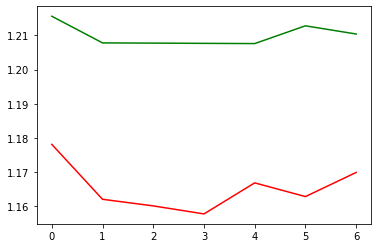

In [222]:
plt.plot(xvalid[:,1], c = 'green')
plt.plot(preds2, c='red')

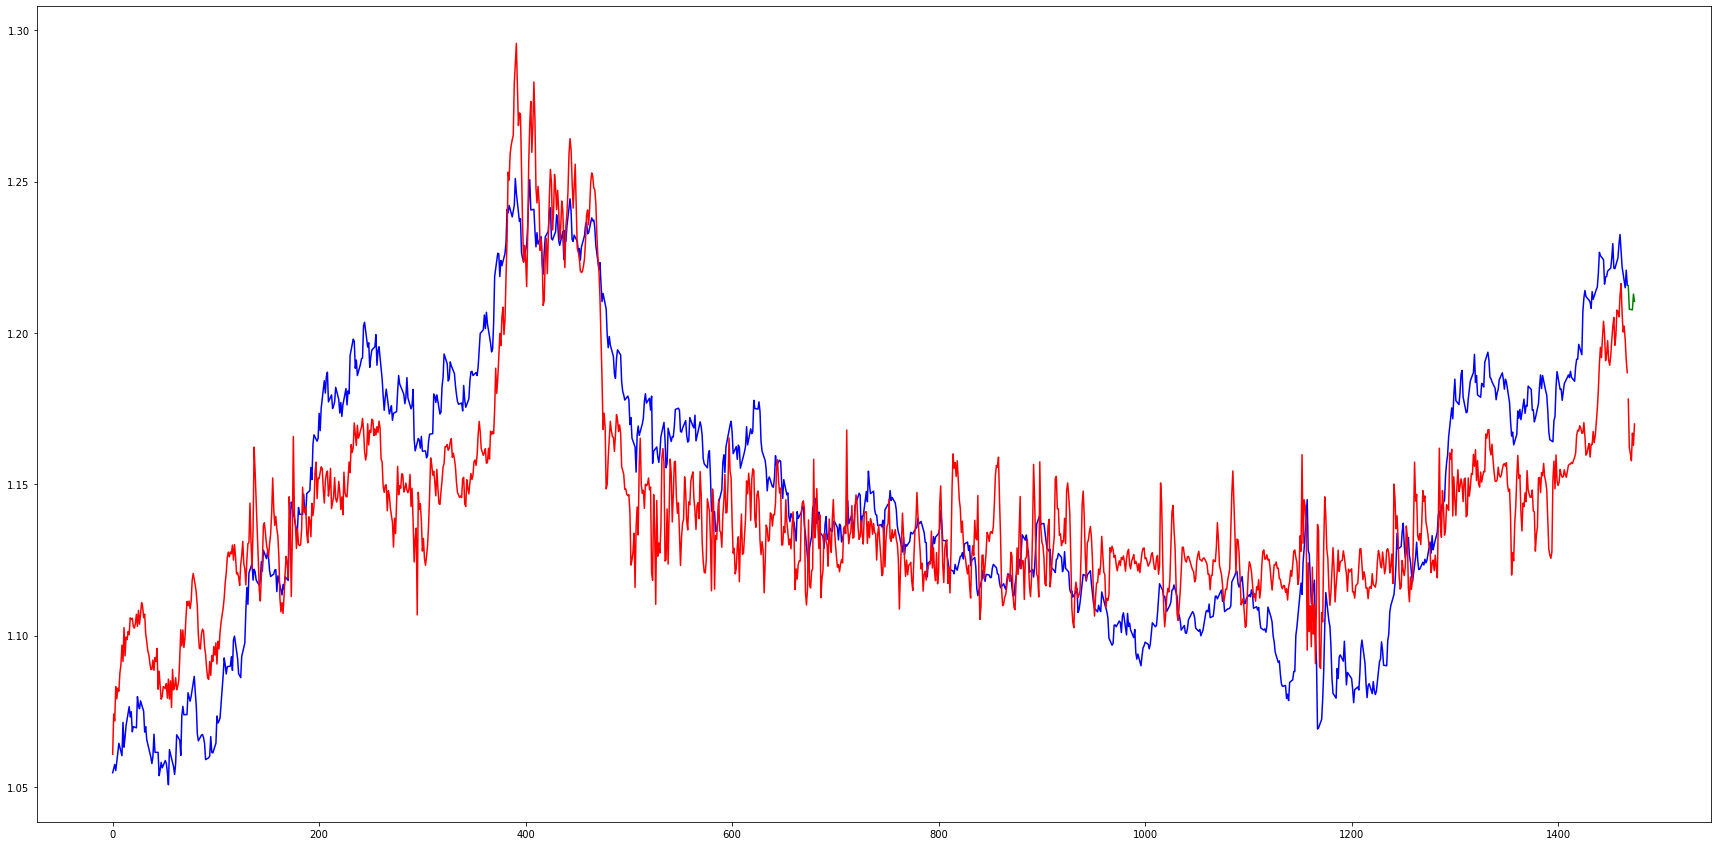

In [223]:
x = np.arange(xtrain.shape[0], xtrain.shape[0] + xvalid.shape[0])
plt.figure(figsize=(30, 15))
plt.plot(xtrain[:,1], c='blue')
plt.plot(preds1, c='red')
plt.plot(x ,xvalid[:,1], c = 'green')
plt.plot(x ,preds2, c='red')
plt.show()